<img src="img/dsci572_header.png" width="600">

# Lecture 2: Optimization & Gradient Descent



<br><br><br>

## Lecture Learning Objectives


- Explain the difference between a model, loss function, and optimization algorithm in the context of machine learning
- Explain how the gradient descent algorithm works
- Apply gradient descent to linear and logistic regression
- Use `scipy.optimize.minimize()` to minimize a function

<br><br><br>

## Imports


In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.plotting import *

%config InlineBackend.figure_formats = ['svg']

![](img/whistler-peaks.jpeg)
[source](https://climberkyle.com/2021/05/15/whistler-mountain-west-gully/)

## Optimization and Machine Learning


- In data science, we optimize a lot of stuff, e.g., in linear regression we optimize for the intercept and coefficients, in clustering we optimize clusters, in neural networks we optimize the weights in our network (more on that in a later lecture), etc.

- In one sentence: optimization simply refers to minimizing/maximizing a function, e.g.:
    - What value of $x$ minimizes the function $f(x) = (x-2)^2 + 5$? What is the minimum value?
    - *Answers*: $x=2$, and $f(x)=5$.

- You can start to think of ML as a 3-step process:

    1. **Choose your model**: controls the space of possible functions that map $X$ to $y$ (e.g., a linear model can only learn linear functions)

    2. **Choose your loss function**: tells us how to compare these various functions (e.g., is $y=5 + 2x_1+3x_2$ a better model than $y=1 + 10x_1-x_2$?)
    3. **Choose your optimization algorithm**: finds the minimum of the loss function (e.g., what is the optimum value of $w_0$ and $w_1$ in $y=w_0 + w_1x$?)

- In this lecture we'll be taking a visual approach to understanding optimization and gradient descent (an optimization algorithm)

<br><br><br>

## Loss Functions


- You discussed loss functions in 573 (also often called "objective functions" or "cost functions", although some debate that these are [slightly different things](https://stats.stackexchange.com/questions/179026/objective-function-cost-function-loss-function-are-they-the-same-thing))

- A loss function is what we use to map the performance of our model to a real number and it's the thing we want to optimize

<br><br><br>

- For example, here's the mean squared error, or MSE, (a common loss function):

$$\text{MSE} = \mathcal{L}(\mathbf{w})=\frac{1}{n}\sum^{n}_{i=1}(\hat{y_i}-y_i)^2$$

- Where $y_i$ is the actual response and $\hat{y_i}$ is the predicted response

- Consider a simple linear regression model $\hat{y_i} = w_0 + w_1 x_i$, then our loss function is:

$$\mathcal{L}(\mathbf{w})=\frac{1}{n}\sum^{n}_{i=1}\left( (w_0 + w_1 x_{i1})-y_i) \right)^2$$

- The optimization problem here is to find the values of $w_0$ and $w_1$ that minimizes the MSE

<br><br><br>

### Notation review

Suppose $\mathbf{X}_{n \times d}$ is your feature matrix and $\mathbf{y}_{n \times 1}$ is the vector of targets. 

$$
\mathbf{y}=
\left[
\begin{array}{c} y_1 \\
\vdots \\
y_i \\
\vdots\\
y_n
\end{array}
\right]_{n \times 1}, \quad
\mathbf{X}=
\left[
\begin{array}{c} \mathbf{x}_1 \\
\vdots \\
\mathbf{x}_i \\
\vdots\\
\mathbf{x}_n
\end{array}
\right]_{n \times d}
= \left[\begin{array}{cccc}
x_{11} & x_{12} & \cdots & x_{1 d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{i 1} & x_{i 2} & \cdots & x_{i d}\\
\vdots & \vdots & \ddots & \vdots \\
x_{n 1} & x_{n 2} & \cdots & x_{n d}
\end{array}\right]_{n \times d},
\quad
\mathbf{w}=
\left[
\begin{array}{c} w_1 \\
\vdots\\
w_d
\end{array}
\right]_{d \times 1}
$$

- $n$: number of examples
- $d$: number of input features/dimensions

The goal is to find the weights $\mathbf{w}$ that minimize the loss function. 

We can write the loss function for a linear regression model in the following two formats:

- **In vector format:**

$$\text{MSE} = \mathcal{L}(\mathbf{w}) = \frac{1}{n}\sum^{n}_{i=1}(\mathbf{x}_i \mathbf{w} - y_i)^2$$

- **In full-matrix format:**

$$\text{MSE} = \mathcal{L}(\mathbf{w}) = \frac{1}{n}(\mathbf{X} \mathbf{w} - \mathbf{y})^T (\mathbf{X} \mathbf{w} - \mathbf{y}) $$

- Note that in the matrix form we don't have to explicitly write the summation. 

<br><br><br>

## Optimizing Linear Regression



- We are going to build up the intuition for optimization in a practical and visual way with the help of our old friend linear regression.

- If you'd prefer a more mathematical approach I encourage you to check out [Chapter 7 of Mathematics for Machine Learning, by Deisenroth et al.](https://mml-book.github.io/book/mml-book.pdf)

- We'll use a dataset of [Pokemon](https://www.pokemon.com/us/) "attack" and "defense" stats to do this. For simplicity, we'll start with just 10 observations:

In [2]:
df = (pd.read_csv("data/pokemon.csv", usecols=['name', 'defense', 'attack'], index_col=0)
        .head(10)
        .sort_values(by='defense')
        .reset_index()
     )
toy_X = df[['defense']].values
toy_y = df['attack'].values
df

name  attack  defense
0    Caterpie      30       35
1  Charmander      52       43
2   Bulbasaur      49       49
3  Charmeleon      64       58
4     Ivysaur      62       63
5    Squirtle      48       65
6   Charizard     104       78
7   Wartortle      63       80
8   Blastoise     103      120
9    Venusaur     100      123

> Throughout this lecture, we'll be leveraging plotting scripts imported from `utils.plotting`.
>
> The code is abstracted out of the notebook to avoid cluttering the lecture notes, and how these plots are made is not that important.

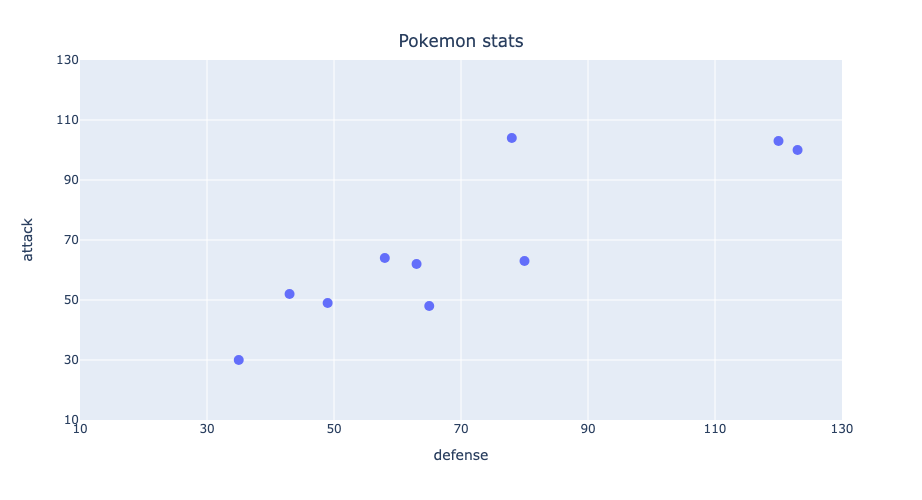

In [3]:
plot_pokemon(toy_X.flatten(), toy_y)

- Recall simple linear regression: $\hat{y_i} = w_0 + w_1x_i$ (where  $w_0$ is the intercept and $w_1$ is the slope coefficient)

- If we assume ($w_0$, $w_1$) = (10, 0.5) we would have:

In [4]:
toy_y_hat = 10 + 0.5*toy_X
toy_y_hat

array([[27.5],
       [31.5],
       [34.5],
       [39. ],
       [41.5],
       [42.5],
       [49. ],
       [50. ],
       [70. ],
       [71.5]])

- Let's plot that result:

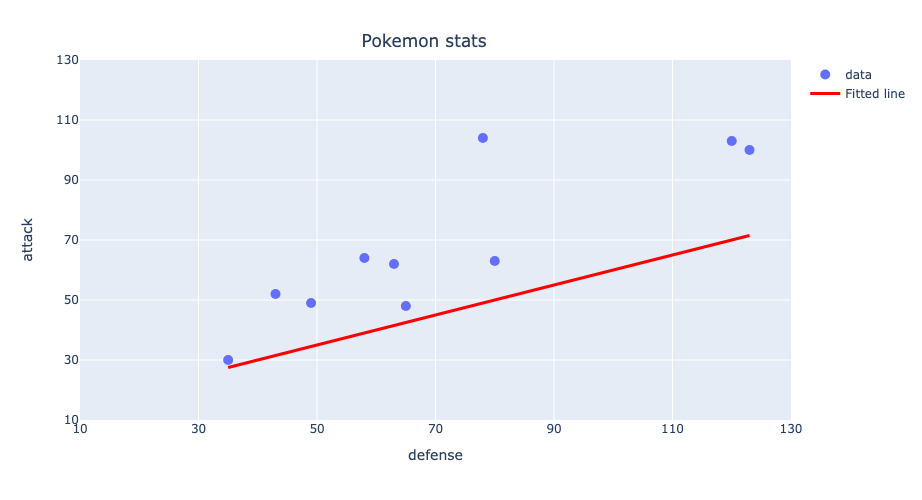

In [5]:
plot_pokemon(toy_X.flatten(), toy_y, toy_y_hat.flatten())

- The fit is not very good... We need to optimize it

- A **loss function** quantifies the fit of our model and we want to find the parameters of our model that minimize the loss function

<br><br><br>

- We'll use mean-squared-error (MSE) as our loss function:

$$\mathcal{L}(w)=\frac{1}{n}\sum^{n}_{i=1}((w_0 + w_1x_{i1})-y_i))^2$$

- Where $n$ is the number of data points we have (10 in our case).

- We'll use the sklearn function `mean_squared_error()` from `sklearn` to calculate MSE for us which is imported at the top of the notebook. 

In [6]:
mean_squared_error(toy_y, toy_y_hat)

680.75

<br><br><br>

- For now, let's assume the intercept is 0 ($w_0 = 0$) and **just focus on optimizing the slope** ($w_1$)

- One thing we could do is try many different values for the slope and find the one that minimizes the MSE:

In [7]:
slopes = np.arange(0.4, 1.65, 0.05)
mse = pd.DataFrame({"$w_1$ (slope)": slopes,
                    "MSE": [mean_squared_error(toy_y, m * toy_X) for m in slopes]})
mse

$w_1$ (slope)        MSE
0            0.40  1770.0760
1            0.45  1478.6515
2            0.50  1216.7500
3            0.55   984.3715
4            0.60   781.5160
5            0.65   608.1835
6            0.70   464.3740
7            0.75   350.0875
8            0.80   265.3240
9            0.85   210.0835
10           0.90   184.3660
11           0.95   188.1715
12           1.00   221.5000
13           1.05   284.3515
14           1.10   376.7260
15           1.15   498.6235
16           1.20   650.0440
17           1.25   830.9875
18           1.30  1041.4540
19           1.35  1281.4435
20           1.40  1550.9560
21           1.45  1849.9915
22           1.50  2178.5500
23           1.55  2536.6315
24           1.60  2924.2360

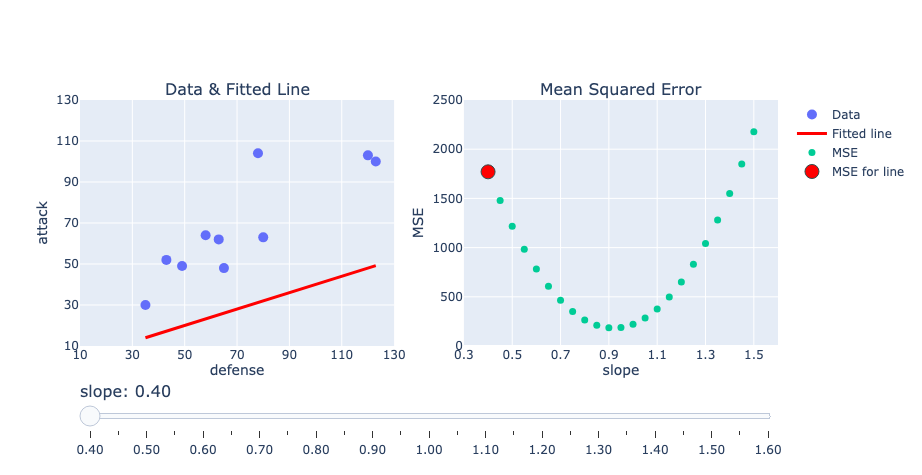

In [8]:
plot_grid_search(toy_X.flatten(), toy_y, slopes, mean_squared_error)

- It looks like a slope of 0.9 gives us the lowest MSE (~184.4)

- But you can imagine that this "grid search" approach quickly becomes computationally intractable as the size of our data set and number of model parameters increases

- So we need a better way to optimize our parameters...
  
- Also, it would be nice if we had a direction or a guide in the parameter space such that the new parameters we choose have a lower loss than the parameters in the previous iteration.  

- One way to get this direction is by computing the **gradient of the loss with respect to the parameters**. In this lecture, we'll focus on one such method called **Gradient Descent**. 

Note that in the context of ordinary least squares, we can get the parameters $w$ directly by solving $(X^TX)^{-1}X^Ty$. But when you have a large dataset or co-linearity, it's better to go with the iterative optimization approaches.   

<br><br><br>

## Gradient Descent With One Parameter


- Gradient descent is an optimization algorithm that can help us optimize our loss function

- As the name suggest, we are going to leverage the **gradient** of our loss function to help us optimize our model parameters

- The gradient is just a vector of partial derivatives of the loss function **w.r.t the model parameters**

<br><br><br>

- The gradient will tell us two things:

    1. Which direction to move our parameter in to decrease loss (i.e., should we increase or decrease its value?)

    2. How much our loss function changes per each unit change in $w$

If you need a refresher on gradients, check out [Appendix A](appendixA_gradients.ipynb)

<br><br><br>

- Let's forget about the intercept now and just work with this simple linear model: $\hat{y_i}=w_1x_{i1}$

- For our model the loss function has the form:

$$\mathcal{L}(w)=\frac{1}{n}\sum^{n}_{i=1}((w_1x_{i1})-y_i))^2$$

<br><br><br><br>

- The gradient of this function with respect to the parameter $w$ is:

$$\nabla \mathcal{L} = \frac{d}{dw}\mathcal{L}(w)=\frac{1}{n}\sum^{n}_{i=1}2x_{i1}(x_{i1}w_1 - y_i)$$

- In matrix format

$$\nabla \mathcal{L} = \frac{d}{dw}\mathcal{L}(w)=\frac{2}{n}X^T (Xw - y)$$

<br><br><br>

- Let's code that up

- Let's calculate the gradient of our loss function at a slope of $w = 0.5$:

In [9]:
def gradient(X, y, w):
    n = len(y)
    return (2/n) * X.T @ (X @ w - y)
    
gradient(toy_X, toy_y, w=np.array([0.5]))

array([-4942.8])

<br><br><br>

- So this is the average gradient across all training examples and tells us how to adjust $w$ to reduce the MSE loss over all training examples!

- Recall from calculus that the **gradient actually points in the direction of steepest ascent** (read more in [Appendix A](appendixA_gradients.ipynb))

- We want to move in the direction of steepest descent (the negative of the gradient) to reduce our loss

<br><br><br>

- For example, the above gradient is negative, but we obviously need to **increase** the value of our slope ($w$) to reduce our loss as you can see here:

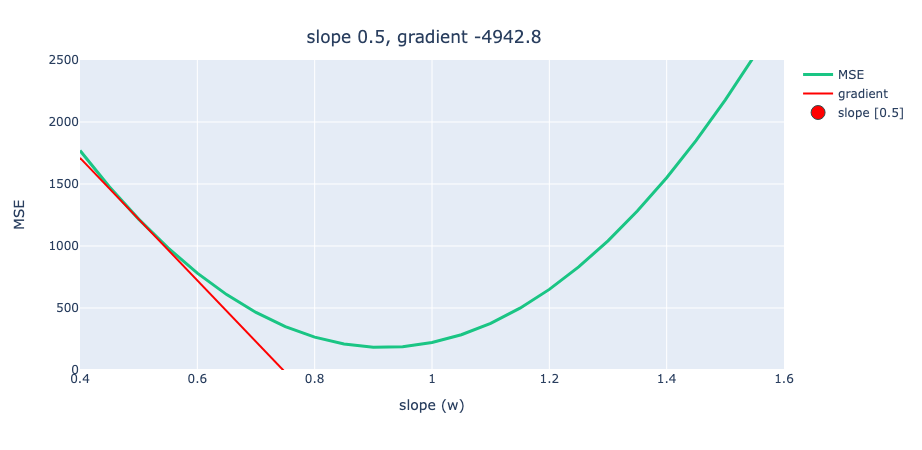

In [10]:
plot_gradient_m(toy_X, toy_y, np.array([0.5]), mse["$w_1$ (slope)"], mse["MSE"], gradient)

- The amount we adjust our slope each iteration is controlled by a "learning rate", denoted $\alpha$ (note the minus in the equation below which accounts for the "descent" as discussed above):

$$w_{new} = w_{old} - \alpha \nabla \mathcal{L}$$

- $\alpha$ is a hyperparameter that can be optimized, typical values range from 0.001 to 0.9

<br><br><br>

- We're now ready to use gradient descent to optimize $w$ to get minimum MSE

- Typically we stop gradient descent when:

    1. the step size (i.e. $\alpha \nabla \mathcal{L}$) is smaller than some threshold; or,
    
    2. a certain number of steps is completed

<br><br><br>

So the pseudo code for gradient descent boils down to this:

- begin with with some arbitrary $w$

- while stopping criteria not met:

  - calculate mean gradient across all examples

  - update w based on gradient and learning rate

  - repeat

<br><br><br>

Let's go ahead and implement that now:

In [11]:
def gradient_descent(X, y, w, alpha, ϵ=1e-4, max_iterations=5000, print_progress=10):
    """Gradient descent for optimizing slope in simple linear regression with no intercept."""
    
    print(f"Iteration 0. w = {w}")
    iterations = 1              # init iterations

    dw=np.full_like(w, np.inf)   # init. dw
    
    while np.linalg.norm(dw) > ϵ and iterations <= max_iterations:
        g = gradient(X, y, w)   # calculate current gradient
        dw = alpha * g          # change in w
        w -= dw                 # adjust w based on gradient * learning rate

        if iterations % print_progress == 0:
            print(f"Iteration {iterations}. w = {w}.")

        iterations += 1        # increase iteration

    print("Terminated!")
    print(f"Iteration {iterations - 1}. w = {w}.")

In [12]:
gradient_descent(toy_X, toy_y, w=np.array([0.5]), alpha=1e-5, print_progress=1)

Iteration 0. w = [0.5]
Iteration 1. w = [0.549428].
Iteration 2. w = [0.59301895].
Iteration 3. w = [0.63146215].
Iteration 4. w = [0.66536553].
Iteration 5. w = [0.69526518].
Iteration 6. w = [0.72163392].
Iteration 7. w = [0.74488873].
Iteration 8. w = [0.76539733].
Iteration 9. w = [0.78348403].
Iteration 10. w = [0.79943483].
Iteration 11. w = [0.81350198].
Iteration 12. w = [0.8259079].
Iteration 13. w = [0.83684878].
Iteration 14. w = [0.84649764].
Iteration 15. w = [0.85500704].
Iteration 16. w = [0.86251155].
Iteration 17. w = [0.86912983].
Iteration 18. w = [0.87496655].
Iteration 19. w = [0.880114].
Iteration 20. w = [0.88465358].
Iteration 21. w = [0.88865707].
Iteration 22. w = [0.89218778].
Iteration 23. w = [0.89530154].
Iteration 24. w = [0.89804759].
Iteration 25. w = [0.90046935].
Iteration 26. w = [0.90260513].
Iteration 27. w = [0.90448868].
Iteration 28. w = [0.90614981].
Iteration 29. w = [0.90761476].
Iteration 30. w = [0.90890672].
Iteration 31. w = [0.91004611].

<br><br><br>

- Let's take a look at the journey our slope parameter went on:

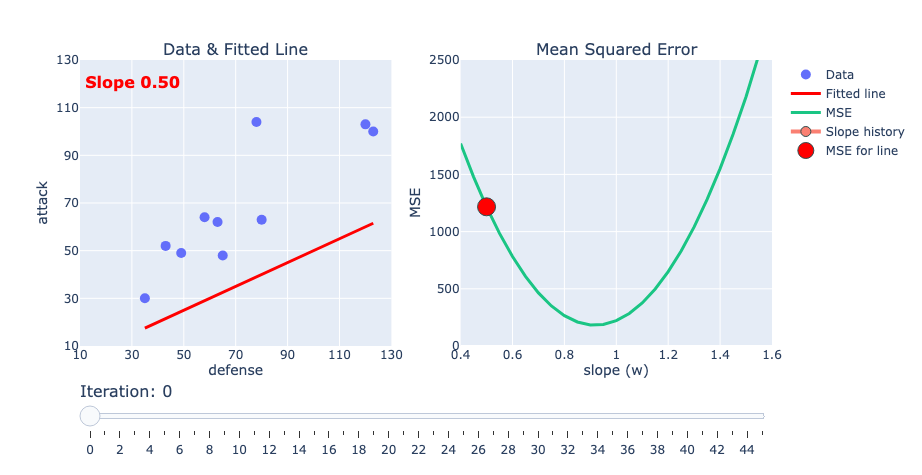

In [13]:
plot_gradient_descent(toy_X, toy_y, w=0.5, alpha=1e-5)

<br><br><br>

- Let's see what happens if we increase the learning rate:

In [14]:
gradient_descent(toy_X, toy_y, w=np.array([0.5]), alpha=5e-5, print_progress=1)

Iteration 0. w = [0.5]
Iteration 1. w = [0.74714].
Iteration 2. w = [0.84835372].
Iteration 3. w = [0.88980478].
Iteration 4. w = [0.90678065].
Iteration 5. w = [0.91373295].
Iteration 6. w = [0.91658019].
Iteration 7. w = [0.91774625].
Iteration 8. w = [0.9182238].
Iteration 9. w = [0.91841937].
Iteration 10. w = [0.91849947].
Terminated!
Iteration 10. w = [0.91849947].


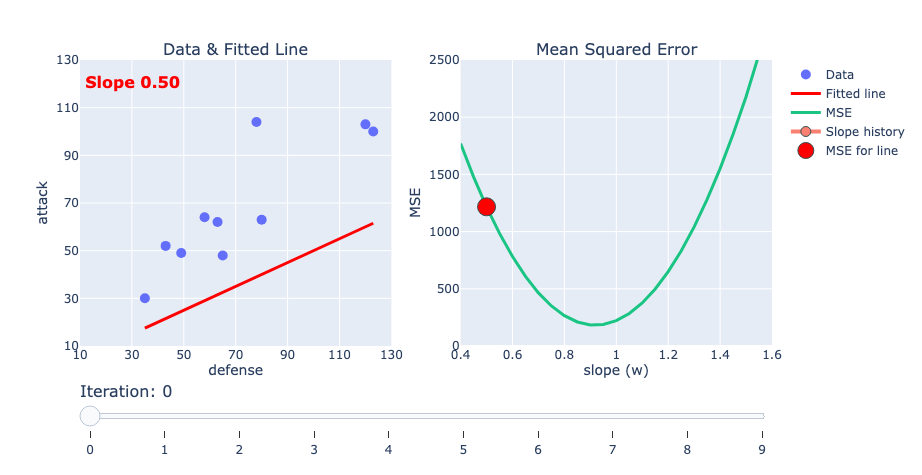

In [15]:
plot_gradient_descent(toy_X, toy_y, w=0.5, alpha=5e-5)

<br><br><br>

- Let's increase a little more:

In [16]:
gradient_descent(toy_X, toy_y, w=np.array([0.5]), alpha=1.5e-4)

Iteration 0. w = [0.5]
Iteration 10. w = [0.88733478].
Iteration 20. w = [0.91622629].
Iteration 30. w = [0.91838132].
Terminated!
Iteration 36. w = [0.91851843].


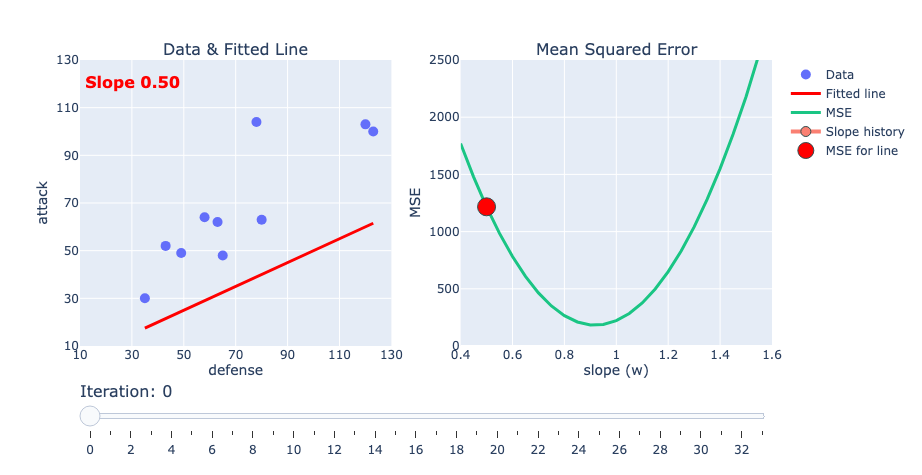

In [17]:
plot_gradient_descent(toy_X, toy_y, w=0.5, alpha=1.5e-4)

<br><br><br>

- If our learning rate is too high, we'll overshoot and never converge!

In [18]:
gradient_descent(toy_X, toy_y, w=np.array([0.5]), alpha=1.8e-4, max_iterations=10, print_progress=1)

Iteration 0. w = [0.5]
Iteration 1. w = [1.389704].
Iteration 2. w = [0.38820335].
Iteration 3. w = [1.51554857].
Iteration 4. w = [0.24654566].
Iteration 5. w = [1.67500639].
Iteration 6. w = [0.067051].
Iteration 7. w = [1.87705564].
Iteration 8. w = [-0.16038694].
Iteration 9. w = [2.13307252].
Iteration 10. w = [-0.44857388].
Terminated!
Iteration 10. w = [-0.44857388].


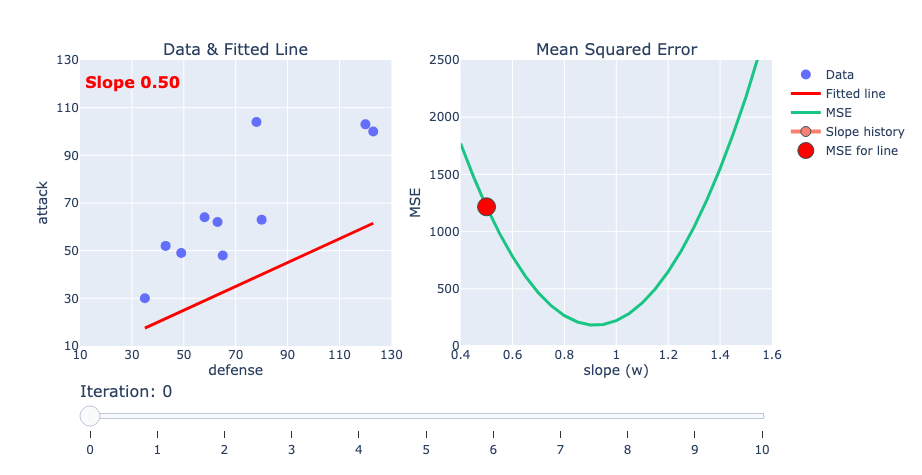

In [19]:
plot_gradient_descent(toy_X, toy_y, w=0.5, alpha=1.8e-4, max_iterations=10)

- Now let's try optimizing for two parameters, intercept and slope, simultaneously.

<br><br><br>

## Gradient Descent With Two Parameters


- Most of the models you'll be working with will have more than just one parameter to update - neural networks typically have hundreds, thousands, and even millions of parameters

- Let's extend the above workflow to two parameters, the intercept ($w_0$) and the slope ($w_1$)

- Just to help you get a visual of what's going on, let's take our _grid search approach_ and make a plot of it but this time with two parameters:

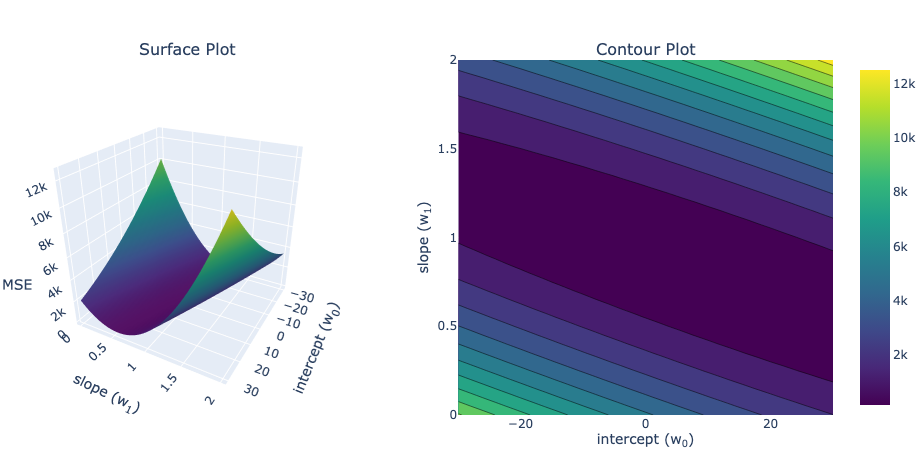

In [20]:
slopes = np.arange(0, 2.05, 0.05)
intercepts = np.arange(-30, 31, 2)
plot_grid_search_2d(toy_X, toy_y, slopes, intercepts)

- Above is the surface of MSE for different values of `intercept` ($w_0$) and `slope` ($w_1$)
- The approach is exactly as before, but we're operating on two parameters now:

$$\mathcal{L}(w)=\frac{1}{n}\sum^{n}_{i=1}((w_0 + w_1x_{i1})-y_i))^2$$

$$\frac{\partial{}}{\partial{}w_0}\mathcal{L}(w)=\frac{1}{n}\sum^{n}_{i=1}2((w_0 + w_1x_{i1}) - y_i)$$

$$\frac{\partial{}}{\partial{}w_1}\mathcal{L}(w)=\frac{1}{n}\sum^{n}_{i=1}2x_{i1}((w_0 + w_1x_{i1}) - y_i)$$

This is taken care of in our matrix format and our gradient function if we use the "column of ones" trick for the bias term.  

$$\nabla \mathcal{L} = \frac{d}{dw}\mathcal{L}(w)=\frac{2}{n}X^T(Xw - y)$$

```python
def gradient(X, y, w):
    n = len(y)
    return (2/n) * X.T @ (X @ w - y)
```

In [21]:
ones = np.ones((len(toy_X),1))
toy_X_ones = np.hstack((ones, toy_X))
toy_X_ones

array([[  1.,  35.],
       [  1.,  43.],
       [  1.,  49.],
       [  1.,  58.],
       [  1.,  63.],
       [  1.,  65.],
       [  1.,  78.],
       [  1.,  80.],
       [  1., 120.],
       [  1., 123.]])

Let's look at a random gradient: 

In [22]:
gradient(toy_X_ones, toy_y, w=np.array([10.0, 0.5]))

array([  -43.6, -3514.8])

The gradients are on a very different scales. When features are not scaled, the gradients are also on a different scale and the parameter space can become skewed and elongated. This happens because different features contribute disproportionately to the loss. This can lead to slower convergence.

When using gradient descent it's recommended to scale the features. 

### Scaling 

In [23]:
scaler = StandardScaler()
toy_X_scaled = scaler.fit_transform(toy_X)

In [24]:
toy_X_scaled.shape[0]

10

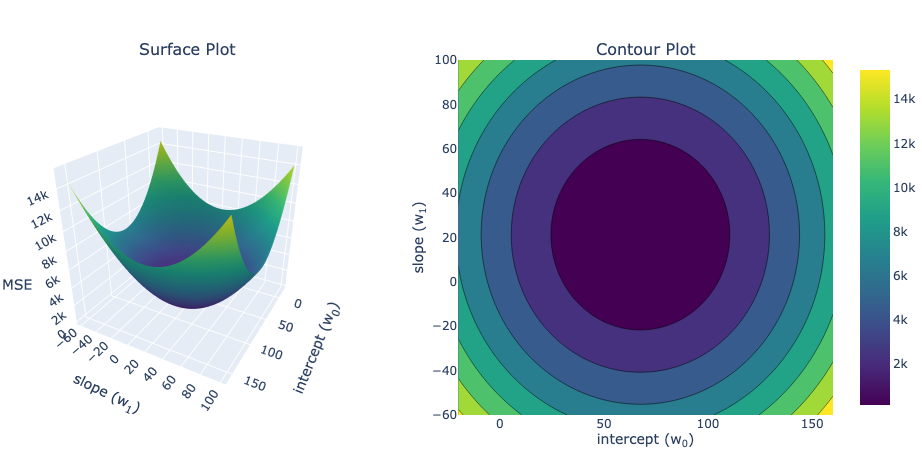

In [25]:
slopes = np.arange(-60, 101, 2)
intercepts = np.arange(-20, 161, 2)
plot_grid_search_2d(toy_X_scaled, toy_y, slopes, intercepts)

- Now let's check a random gradient:

In [26]:
ones = np.ones((len(toy_X), 1))
toy_X_scaled_ones = np.hstack((ones, toy_X_scaled))  # add column of ones for the intercept term
toy_X_scaled_ones

array([[ 1.        , -1.28162658],
       [ 1.        , -0.99995041],
       [ 1.        , -0.78869328],
       [ 1.        , -0.47180759],
       [ 1.        , -0.29575998],
       [ 1.        , -0.22534094],
       [ 1.        ,  0.23238284],
       [ 1.        ,  0.30280188],
       [ 1.        ,  1.71118274],
       [ 1.        ,  1.81681131]])

In [27]:
gradient(toy_X_scaled_ones, toy_y, w=np.array([10.0, 0.5]))

array([-115.        ,  -41.54718577])

The scales of gradients seem better than before. 

In [28]:
gradient_descent(toy_X_scaled_ones, toy_y, w=[10.0, 2.0], alpha=0.2)

Iteration 0. w = [10.0, 2.0]
Iteration 10. w = [67.15231949 21.15705284].
Iteration 20. w = [67.49789771 21.27288821].
Terminated!
Iteration 26. w = [67.49990192 21.27356001].


Let's compare it with LinearRegression

In [29]:
lr = LinearRegression()
lr.fit(toy_X_scaled, toy_y)

LinearRegression()

In [30]:
lr.coef_, lr.intercept_

(array([21.27359289]), 67.5)

- The coefficients from our gradient descent implementation match perfectly with sklearn implementation!

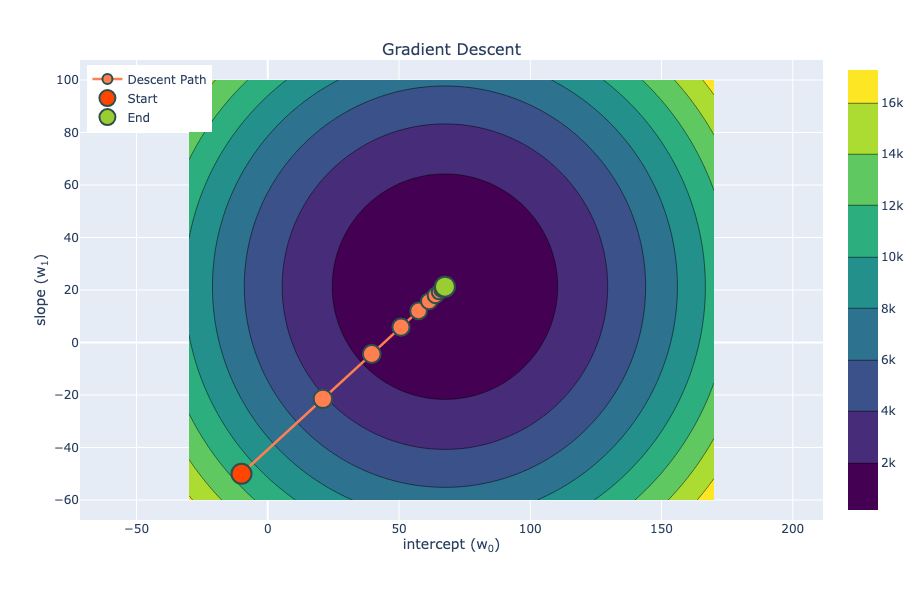

In [31]:
plot_gradient_descent_2d(toy_X_scaled, toy_y, w=[-10, -50],
                         alpha=0.2,
                         m_range=np.arange(-60, 101, 2),
                         b_range=np.arange(-30, 171, 2),
                         markers=True)

- Once again, changing the learning rate will affect our descent (I added some markers on this plot to show you that we're bouncing back-and-forth):

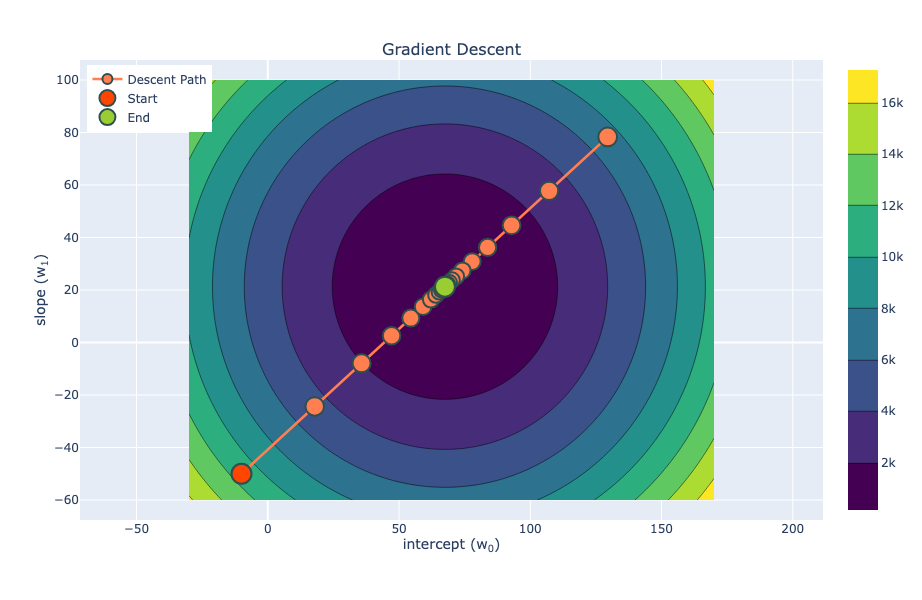

In [32]:
plot_gradient_descent_2d(toy_X_scaled, toy_y, w=[-10, -50],
                         alpha=0.9,
                         m_range=np.arange(-60, 101, 2),
                         b_range=np.arange(-30, 171, 2),
                         markers=True)

<br><br><br>

- Real-life loss functions of neural networks are rarely this smooth-looking and well-behaving. Here is a picture of the **loss landscape** of a complex neural network model for image recognition:

<img src="img/loss_landscape.png" width="500">

[image source](https://www.cs.umd.edu/~tomg/projects/landscapes/)

<br><br><br>

## Other Optimization Algorithms


- When you saw us using gradients earlier on you might have thought, why not just set the derivative to 0 and solve?

- You sure could do this. And in general, if a closed form solution exists for your problem, you should typically use it

- However:

    - Most problems in ML do not have a closed-form solution
    
    - Even if a closed form solution exists (e.g., linear regression), it can be extremely computationally expensive to compute if your dataset is large (many observations and/or many features)

- In these cases, optimization algorithms like GD are appropriate choices

- In actuality you will almost never use vanilla GD in practice because it's slow and expensive to compute (but the intuition behind it forms the basis of tons of optimization algorithms so it's a great place to start learning)

- We'll look at a computationally lighter version of GD next lecture (stochastic gradient descent) and there are also many other algorithms available

- You can explore the `scipy` function `minimize` to play around with some of these algorithms (read the documentation [here](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#unconstrained-minimization-of-multivariate-scalar-functions-minimize)):

In [33]:
from scipy.optimize import minimize

- Here was our gradient descent implementation:

In [34]:
gradient_descent(toy_X_scaled_ones, toy_y, w=np.array([10.0, 2.0]), alpha=0.2)

Iteration 0. w = [10.  2.]
Iteration 10. w = [67.15231949 21.15705284].
Iteration 20. w = [67.49789771 21.27288821].
Terminated!
Iteration 26. w = [67.49990192 21.27356001].


- `minimize` takes as argument the function to minimize, the function's gradient and the starting parameter values

- For a linear regression model, the MSE loss and gradient take the general form in matrix format:

$$\mathcal{L}(\mathbf{w})_{MSE} = \frac{1}{n}(\mathbf{X} \mathbf{w} - \mathbf{y})^2 $$

$$\frac{\partial{\mathcal{L}}}{\partial w}_{MSE}=\frac{2}{n}\mathbf{X}^T(\mathbf{X}\mathbf{w} - \mathbf{y})$$

<br><br><br>

<br><br><br>

- Let's code them up using matrix multiplication:

In [35]:
# For our sanity, let's scale the data again
scaler = StandardScaler()
X_scaled = scaler.fit_transform(toy_X)

In [36]:
w = np.array([10, 2])
X_scaled_ones = np.hstack((np.ones((len(X_scaled), 1)), X_scaled))  # appening a column of 1's for the intercept
X_scaled_ones

array([[ 1.        , -1.28162658],
       [ 1.        , -0.99995041],
       [ 1.        , -0.78869328],
       [ 1.        , -0.47180759],
       [ 1.        , -0.29575998],
       [ 1.        , -0.22534094],
       [ 1.        ,  0.23238284],
       [ 1.        ,  0.30280188],
       [ 1.        ,  1.71118274],
       [ 1.        ,  1.81681131]])

To call `minimize`, we need the loss function and optionally need the function which calculates the gradient.  

In [37]:
def mse(w, X, y):
    """Mean squared error."""
    return np.mean((X @ w - y) ** 2)

def mse_grad(w, X, y):
    """Gradient of mean squared error."""
    n = len(y)
    return (2/n) * X.T @ (X @ w - y)

<br><br><br>

- Now we can call `minimize`:

In [38]:
out = minimize(mse, w, jac=mse_grad, args=(X_scaled_ones, toy_y), method="BFGS")

**Note:** You don't need to necessarily supply the gradient function (also called the Jacobian matrix, that is provided to the `jac=` parameter) for all optimization methods. If the gradient (the Jacobian) is not provided, it will be numerically approximated with a finite-difference scheme.

In [39]:
out

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 155.48424576019033
        x: [ 6.750e+01  2.127e+01]
      nit: 2
      jac: [-6.883e-15 -1.377e-14]
 hess_inv: [[ 5.505e-01 -1.507e-01]
            [-1.507e-01  9.495e-01]]
     nfev: 5
     njev: 5

In [40]:
out.x # the learned parameters 

array([67.5       , 21.27359289])

<br><br><br>

- There are plenty of other optimization methods implemented in SciPy that you can look into ([documentation](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#unconstrained-minimization-of-multivariate-scalar-functions-minimize)):

In [41]:
for method in ["CG", "L-BFGS-B", "SLSQP", "TNC"]:
    print(f"Method: {method}, Weights: {minimize(mse, w, args=(X_scaled_ones, toy_y), method=method).x}")

Method: CG, Weights: [67.50000045 21.27359024]
Method: L-BFGS-B, Weights: [67.49999858 21.27359273]
Method: SLSQP, Weights: [67.50000084 21.27359037]
Method: TNC, Weights: [67.49504692 21.26815196]


In [42]:
lr = LinearRegression()
lr.fit(X_scaled, toy_y)

LinearRegression()

In [43]:
lr.coef_, lr.intercept_

(array([21.27359289]), 67.5)

<br><br><br>

## Lecture Exercise: Optimizing Logistic Regression


- In this section we are going to optimize a Logistic Regression problem to reinforce some of the points we learned in this lecture

- We'll sample 70 "legendary" (which are typically super-powered) and "non-legendary" pokemon from our dataset

In [44]:
df = pd.read_csv("data/pokemon.csv", index_col=0, usecols=['name', 'defense', 'legendary']).reset_index()
leg_ind = df["legendary"] == 1
df = pd.concat(
    (df[~leg_ind].sample(sum(leg_ind), random_state=123), df[leg_ind]),
    ignore_index=True,
).sort_values(by='defense')

In [45]:
df.head(10)

name  defense  legendary
23     Sunkern       30          0
2       Gastly       30          0
127     Cosmog       31          1
25      Mankey       35          0
5     Remoraid       35          0
6       Kirlia       35          0
60     Tyrogue       35          0
67   Poochyena       35          0
58      Buizel       35          0
11      Noibat       35          0

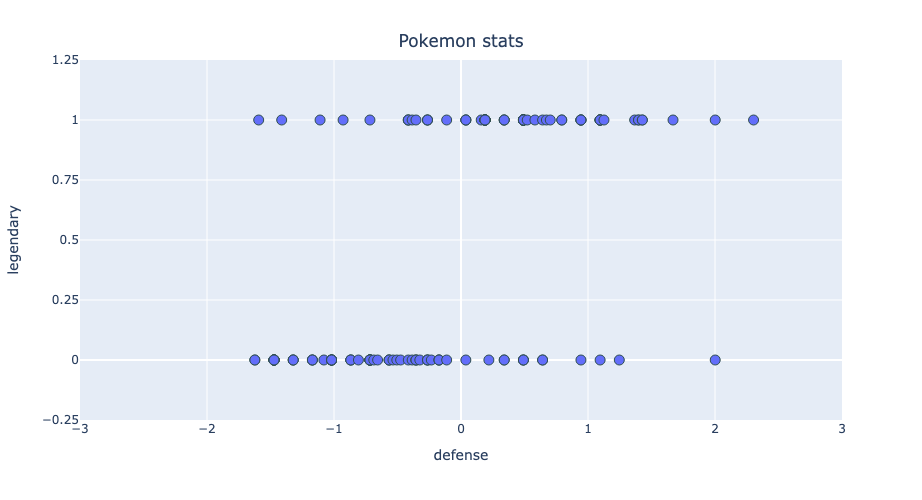

In [46]:
X_scaled = StandardScaler().fit_transform(df[['defense']]).flatten()  # we saw before the standardizing is a good idea for optimization
y = df['legendary'].to_numpy()
plot_logistic(X_scaled, y)

<br><br><br>

- We'll be using the **"trick of ones"** to help us implement these computations efficiently

- For example, if we have a simple linear regression model with an intercept and a slope:

$$\hat{y} = \boldsymbol{x}\boldsymbol{w} = w_0\times{}1 + w_1\times{}x$$

- Let's represent that in matrix form:

$$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}=\begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$$

<br><br><br>

- Now we can calculate $\mathbf{y}$ using matrix multiplication and the "matmul" (i.e. `@`) NumPy operator:

In [47]:
w = np.array([2, 3])
X = np.array([[1, 5], [1, 3], [1, 4]])
X @ w

array([17, 11, 14])

![](img/matmul.png)

- We're going to create a logistic regression model to classify a Pokemon as "legendary" or not

- Recall that in logistic regression we map our linear model to a probability:

$$z=\boldsymbol{x}\boldsymbol{w}$$

$$P(y = 1) = \frac{1}{(1+\exp(-z))}$$

- For classification purposes, we typically then assign this probability to a discrete class (0 or 1) based on a threshold (0.5 by default):

$$y=\left\{
\begin{array}{ll}
    0, & P(y = 1)\le0.5 \\
    1, & P(y = 1)>0.5 \\
\end{array} 
\right.$$

In [48]:
def sigmoid(X, w, output="soft", threshold=0.5):

    p = 1 / (1 + np.exp(-X @ w))
    
    if output == "soft":
        return p
    elif output == "hard":
        return np.where(p > threshold, 1, 0)

- For example, if $w = [5, 3.5]$:

In [49]:
ones = np.ones((len(X_scaled), 1))
X = np.hstack((ones, X_scaled[:, None]))  # add column of ones for the intercept term
w = [5, 3.5]

In [50]:
y_soft = sigmoid(X, w)
y_hard = sigmoid(X, w, "hard")

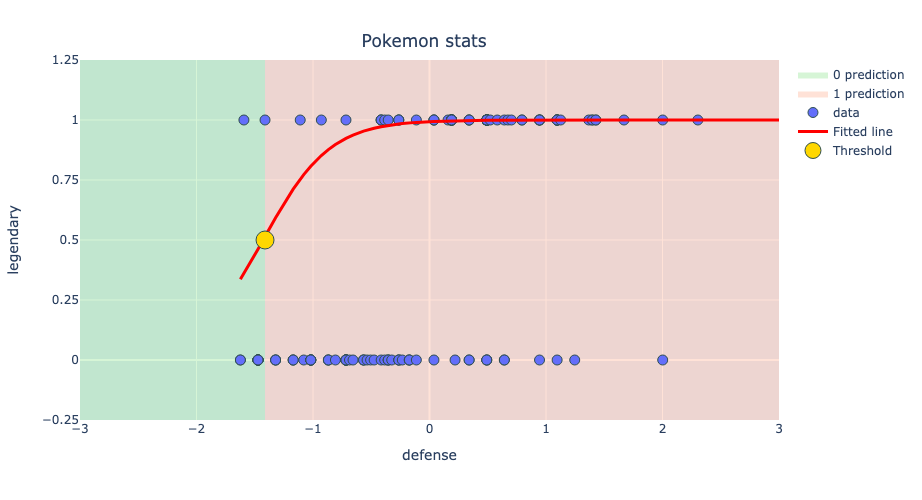

In [51]:
plot_logistic(X_scaled, y, y_soft, threshold=0.5)

- Let's calculate the accuracy of the above model:

In [52]:
def accuracy(y, y_hat):
    return (y_hat == y).sum() / len(y)

accuracy(y, y_hard)

0.5642857142857143

- Just like in the linear regression example earlier, we want to optimize the values of our weights

- We need a loss function

- As you discussed in 573, we use the log loss (cross-entropy loss) to optimize logistic regression
- Here's the loss function and its gradient:
  
$$f(w)=-\frac{1}{n}\sum_{i=1}^ny_i\log\left(\frac{1}{1 + \exp(-w^Tx_i)}\right) + (1 - y_i)\log\left(1 - \frac{1}{1 + \exp(-w^Tx_i)}\right)$$

$$\frac{\partial f(w)}{\partial w}=\frac{1}{n}\sum_{i=1}^nx_i\left(\frac{1}{1 + \exp(-w^Tx_i)} - y_i\right)$$

- In Section 5.10 Advanced: Deriving the Gradient Equation of [this chapter](https://web.stanford.edu/~jurafsky/slp3/5.pdf) you will find the derivation of the derivative of logistic regression loss function.
- See [Appendix B](appendixB_logistic-loss.ipynb) if you want to learn more about these. 

In [53]:
def logistic_loss(w, X, y):
    return -(y * np.log(sigmoid(X, w)) + (1 - y) * np.log(1 - sigmoid(X, w))).mean()


def logistic_loss_grad(w, X, y):
    return (X.T @ (sigmoid(X, w) - y)) / len(X)

In [54]:
w_opt = minimize(logistic_loss, np.array([-1, 1]), jac=logistic_loss_grad, args=(X, y)).x
w_opt

array([0.05153269, 1.34147091])

<br><br><br>

- Let's check our solution against the `sklearn` implementation:

In [55]:
lr = LogisticRegression(penalty=None).fit(X_scaled.reshape(-1, 1), y)
print(f"w0: {lr.intercept_[0]:.2f}")
print(f"w1: {lr.coef_[0][0]:.2f}")

w0: 0.05
w1: 1.34


<br><br><br>

- This is what the optimized model looks like:

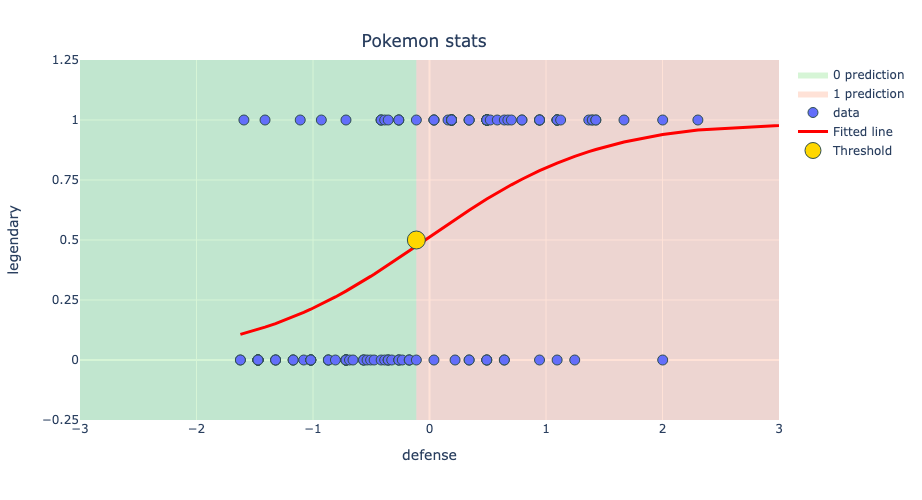

In [56]:
y_soft = sigmoid(X, w_opt)
plot_logistic(X_scaled, y, y_soft, threshold=0.5)

In [57]:
y_hard = sigmoid(X, w_opt, "hard")
accuracy(y, y_hard)

0.8

- Checking that against our sklearn model:

In [58]:
lr.score(X_scaled.reshape(-1, 1), y)

0.8

<br><br><br>

- We replicated the sklearn behaviour from scratch

- By the way, we have been doing things in 2D here because it's easy to visualize, but let's double check that we can work in more dimensions by using `attack`, `defense` and `speed` to classify a Pokemon as `legendary` or not:

In [59]:
df = pd.read_csv("data/pokemon.csv", index_col=0, usecols=['name', 'defense', 'attack', 'speed', 'legendary']).reset_index()
leg_ind = df["legendary"] == 1
df = pd.concat(
    (df[~leg_ind].sample(sum(leg_ind), random_state=123), df[leg_ind]),
    ignore_index=True,
)
df.head()

name  attack  defense  speed  legendary
0  Roggenrola      75       85     15          0
1       Gible      70       45     42          0
2      Gastly      35       30     80          0
3       Minun      40       50     95          0
4      Marill      20       50     40          0

In [60]:
x = StandardScaler().fit_transform(df[["defense", "attack", "speed"]])
X = np.hstack((np.ones((len(x), 1)), x))
y = df["legendary"].to_numpy()

In [61]:
w_opt = minimize(logistic_loss, np.zeros(X.shape[1]), jac=logistic_loss_grad, args=(X, y), method="L-BFGS-B").x
w_opt

array([-0.23259512,  1.33705304,  0.52029373,  1.36780376])

In [62]:
lr = LogisticRegression(penalty=None).fit(x, y)
print(f"w0: {lr.intercept_[0]:.2f}")
for n, w in enumerate(lr.coef_[0]):
    print(f"w{n+1}: {w:.2f}")

w0: -0.23
w1: 1.34
w2: 0.52
w3: 1.37


<br><br><br>

## Lecture Highlights


1. Loss functions and optimization algorithms are different things

    - Loss functions map the performance of your model to a number

    - Optimization algorithms find the model parameters that minimize the loss function

2. Gradient descent is an optimization algorithm, you can find others in `scipy.optimize.minimize()`

3. Gradient descent is simple to code, but not very efficient (it uses all the data to update weights each iteration). We'll explore a computationally cheaper variant of gradient descent in the next lecture.